# Pytorch Example

This example is run on Google Colab which is built on Jupyter Notebook.

Jupyter Notebook can be a useful tool for quickly writing code, displaying results, and annotating sections of code using markup.


In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from scipy.stats import kde
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import Tensor, from_numpy
from collections import defaultdict
from tqdm.notebook import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random

# Adding Custom Python Modules and Github Datasets

Google Colab allows us to use either a temporary directory or mount your Google Drive. This can be useful for
- Importing and saving training/testing data.
- Custom defined library files
- Saving and importing trained models.

(Normal Jupyter notebooks can also import python library files)

In [2]:
# Command to mount your Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')
"""

# Copying a module from Google Drive to our temporary directory to import
# Google Drive starts from "drive/MyDrive"
"""
!cp drive/MyDrive/ProjectFolder/sample_lib.py .
import sample_lib
"""

# Cloning a Github repository to our temporary directory
# Note: The repository has to be public
!git clone -b main https://github.com/cai-michael/ml-projects.git
!cp ml-projects/sample-compbio-project/data/breast-cancer-wisconsin.csv .
!cp ml-projects/sample-compbio-project/sample_lib.py .
import sample_lib

sample_lib.test_import()

fatal: destination path 'comp-bio-ml-project' already exists and is not an empty directory.
You have successfully imported a library!


# GPU/CUDA for Pytorch
Pytorch utilizes CUDA in order to help speed up training and parallel processing.

We can utilize CPUs to train models but depending on the model size and density training can be very slow. This block of code allows us to check to see if any GPUs are available to us and assign one of them to the device variable. Otherwise we consider our device to be the CPU.

To select a GPU in Google Colab:
Runtime -> Change runtime type -> Hardware Accelerator -> GPU

In [3]:
"""
This cell displays the machine's GPU Information
If you are utilizing a machine with multiple GPUs change the device_num until the correct one is displayed.
Google Colab should always use device 0.
"""
if torch.cuda.is_available():
    device_num = 0
    print("Number of GPUs Available: ", torch.cuda.device_count())
    print("Name of Selected GPU: ", torch.cuda.get_device_name(device_num))
    device = torch.device(f"cuda:{device_num}")
else:
    print("Utilizing CPU")
    device = torch.device("cpu")

Utilizing CPU


# Data Preprocessing and Loading

You should always take a look through the data you're training and testing on. There's multiple things that might be interesting or wrong with it.

Examples included here:
- Irrelevant Data
- Missing Data
- Non-Discretized Data

In [4]:
# Read the data using Pandas
dataset = pd.read_csv('breast-cancer-wisconsin.csv', header=0)

# Drop irrelevant data
dataset = dataset.drop(columns=['Sample Number'])

# Clean NaN values
print('Missing Values')
print(dataset.isna().sum(), '\n')
dataset = dataset.dropna()

# Although we dropped the NaN values it might be better to keep those in.
# We may do this a few ways for example using the average value:
"""
# dataset["Bare Nuclei"].fillna(dataset["Bare Nuclei"].average())
"""

# Discretize Classes
print('Classes of tumors')
print(dataset['Class'].unique(), '\n')
class_dict = {
    "benign" : 0,
    "malignant" : 1,
}
dataset = dataset.replace({"Class": class_dict})

dataset

Missing Values
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64 

Classes of tumors
['benign' 'malignant'] 



,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,0
695,2,1,1,1,2,1.0,1,1,1,0
696,5,10,10,3,7,3.0,8,10,2,1
697,4,8,6,4,3,4.0,10,6,1,1


# Describe the Data

It's good to look at your data distribution to ensure you're getting a good sample of data. Look out for fields that have just a single value or imbalances classes. Various factors can lead to bad models either during training or testing, or possibly down the line when tested on out-of-sample data.

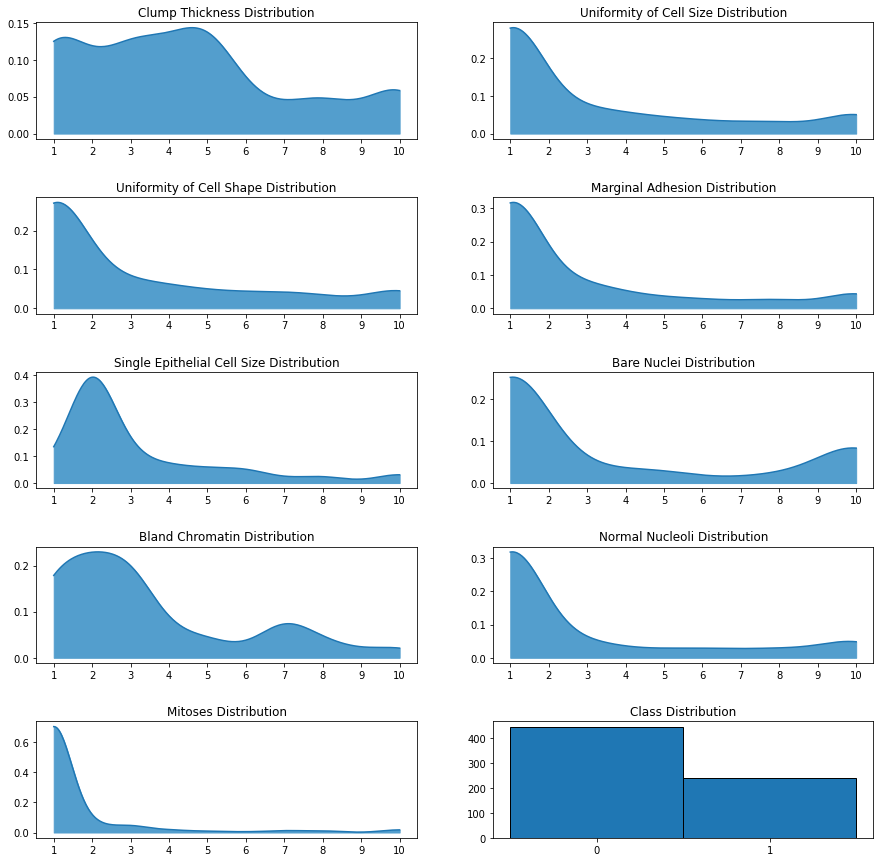

In [5]:
# Show Data Distribution
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)


axs[4][1].hist(dataset['Class'], bins=[-.5,.5,1.5], ec="k") #.plot.bar(title='Class Distribution')
axs[4][1].set_xticks((0,1))
axs[4][1].set_title('Class Distribution')

for i in range(0, 9):
  ax = axs[i // 2][i % 2]
  column = dataset.columns[i]
  density = kde.gaussian_kde(dataset[column])
  x = np.linspace(1,10,300)
  y = density(x)
  ax.plot(x, y)
  ax.set_xticks([i for i in range(1, 11)])
  ax.fill_between(x, y, color='#539ecd')
  ax.set_title(column + ' Distribution')

# Datasets and Dataloaders
In PyTorch we define move our data into a Dataset, which allows us to divide up our original Pandas dataframe. At its simplest we can divide it into X and Y values. Where our X value is our features, and our Y values are the values we wish to predict using our X values. But you could possibly divide this up even more, separating out specific inputs to use in different ways in your structure.

We've also defined a custom splitting method here, which allows us to automatically split our data into a training set, validation set, and testing set.

We can then put each Dataset in a Dataloader, which enables us to iterate through our data in "minibatches". Essentially we can look at a few examples at a time instead of one by one.

In [6]:

"""
Dataset Definition
"""
class ProblemDataset(Dataset):
    def __init__(self, df):
        # Our X values or features are going to be all columns before the last
        self.X = df.values[:, :-1]
        # Our y values or classes are going to be the last column only
        self.y = df.values[:, -1]
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
 
    # Returns number of rows in dataset
    def __len__(self):
        return len(self.X)
 
    # Returns an individual row in the dataset
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # Get indices for training/validation/testing splits.
    # This is stratified by the y value, meaning equal distribution of pos/neg
    def get_splits(self, n_test=0.2, n_val=0.2):
        n_holdout = n_test + n_val
        test_val_ratio = n_test / n_holdout
        x_train, x_holdout, y_train, y_holdout = train_test_split(self.X, self.y, test_size=n_holdout, stratify=self.y)
        x_val, x_test, y_val, y_test = train_test_split(x_holdout, y_holdout, test_size=test_val_ratio, stratify= y_holdout)
        train_dataset = TensorDataset(from_numpy(x_train), from_numpy(y_train))
        valid_dataset = TensorDataset(from_numpy(x_val), from_numpy(y_val))
        test_dataset = TensorDataset(from_numpy(x_test), from_numpy(y_test))
        return train_dataset, valid_dataset, test_dataset

"""
Creates the dataloaders for the train/validation/test sets
"""
def create_dataloaders(df, batch_size=1):
    # Load the dataset
    dataset = ProblemDataset(df)
    # Create the train/validation/testing splits
    train, validation, test = dataset.get_splits()
    # Prepare the Data Loaders
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    validation_dl = DataLoader(validation, batch_size=1024, shuffle=False)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, validation_dl, test_dl


# Helper Functions

I've created a few helper functions here to help with training and evaluation of models.

In [7]:
"""
Given a list of actual values versus predictions, calculates several statistics.
- Accuracy
- AUC (Area Under Curve)
- Recall
- Precision
"""

def evaluate_predictions(y, yhat):
    yhat, y = np.vstack(yhat), np.vstack(y)
    acc = accuracy_score(y, yhat)
    auc = roc_auc_score(y, yhat)
    recall = recall_score(y, yhat)
    prec = precision_score(y, yhat)
    return acc, auc, recall, prec
  

"""
Given a model's prediction values and their actual targets record its 
performance in a dictionary.
"""
def record_training_performance(actuals, predictions, training_notes, epoch):
    acc, auc, recall, prec = evaluate_predictions(actuals, predictions)
    training_notes['train_acc'].append((epoch, acc))
    training_notes['train_auc'].append((epoch, auc))
    training_notes['train_recall'].append((epoch, recall))
    training_notes['train_precision'].append((epoch, prec))

"""
Given a dataloader, record a model's performance on it.
"""
def record_validation_performance(val_dl, model, training_notes, epoch):
    acc, auc, recall, prec = evaluate_model(val_dl, model)
    training_notes['val_acc'].append((epoch, acc))
    training_notes['val_auc'].append((epoch, auc))
    training_notes['val_recall'].append((epoch, recall))
    training_notes['val_precision'].append((epoch, prec))

"""
Trains the model for X epochs.
"""
def train(train_dl, val_dl, model, total_epoch, criterion, optimizer):
    # Dictionary to keep track of the training statistics
    training_notes = defaultdict(list)
    for epoch in tqdm_notebook(range(total_epoch)):
        # enumerate mini batches
        actuals, predictions = list(), list()
        for i, (inputs, targets) in enumerate(train_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            # Clear the Gradients
            optimizer.zero_grad()
            # Compute the Model Predictions
            yhat = model(inputs)
            # Calculate Loss
            targets = targets.unsqueeze(1)
            loss = criterion(yhat, targets)
            # Update Model Weights
            loss.backward()
            optimizer.step()
            # Store actual and Predictions for Evaluation
            yhat = yhat.cpu().detach().numpy().round()
            actual = targets.cpu().numpy()
            actual = actual.reshape((len(actual), 1))
            predictions.append(yhat)
            actuals.append(actual)
        record_training_performance(actuals, predictions, training_notes, epoch)
        record_validation_performance(val_dl, model, training_notes, epoch)
    return training_notes
 
"""
Evaluates the models against another dataset.
- eval_dl: Dataset to be used for evaluation
- model: Trained model to be evaluated
"""
def evaluate_model(eval_dl, model):
    actuals, predictions = list(), list()
    for i, (inputs, targets) in enumerate(eval_dl):
        # Evaluate the model against the given dataset
        inputs = inputs.to(device)
        targets = targets.to(device)
        yhat = model(inputs)
        # Store actual and predictions for Evaluation
        yhat = yhat.cpu().detach().numpy().round()
        actual = targets.cpu().numpy()
        actual = actual.reshape((len(actual), 1))
        predictions.append(yhat)
        actuals.append(actual)
    acc, auc, recall, prec = evaluate_predictions(actuals, predictions)
    return acc, auc, recall, prec

"""
Makes a prediction for one row of data
- eval_dl: Single datapoint to make a prediction for.
- model: Trained model to be evaluated
"""
def predict(x, model):
    # Create a tensor from row of data
    x = Tensor([x])
    # Run model on data
    yhat = model(x)
    # Retrieve Prediction
    yhat = yhat.detach().numpy().round()
    return yhat

# Model Definition
We can now define our PyTorch model. 

We should define a simple function where we specify our training parameters.

Then we can define the structure of our model in another class.

More information on the available structures available here.
  - https://pytorch.org/docs/stable/nn.html

In [8]:
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss
from torch.optim import Adam

# Optimization Definition
def train_model(train_dl, validation_dl, model):
    # Define Optimization Parameters
    criterion = BCELoss()
    optimizer = Adam(model.parameters(), lr=0.0001)
    epochs = 200
    training_notes = train(train_dl, validation_dl, model, epochs, criterion, optimizer)
    return training_notes

# Model Definition
class Net(Module):
    # Define the structure here
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        self.hidden = Linear(n_inputs, 5)
        self.hidden_activation_function = ReLU()
        # Basic Layer
        self.transform = Linear(5, 1)
        self.activation_function = Sigmoid()
 
    # Define the order for the structure
    def forward(self, X):
        """
        The current structure takes an input Tensor of size [1, 20].
        It is transformed into a Tensor of size [1, 4] using linear transformations
        Then transformed into a Tensor of size [1, 2] using linear transformations
        Then transformed into a Tensor of size [1, 1] using the Sigmoid function
        """
        X = self.hidden(X)
        X = self.hidden_activation_function(X)

        X = self.transform(X)
        X = self.activation_function(X)
        return X

# Main Function

This is where we take everything we've built so far and let it run.

Libraries like time and tqdm allow us to the see the progress of our training.

In [9]:
# Define a Training Seed (To make your training reproducible)
seed = 598
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Prepare the data
# Currently network size is passed in based on the inputs
model = Net(9)
train_dl, validation_dl, test_dl = create_dataloaders(dataset)
print("Training Data Count: ", len(train_dl.dataset))
print("Validation Data Count: ", len(validation_dl.dataset))
print("Testing Data Count: ", len(test_dl.dataset))
model.to(device)

# Train the model
print("Starting Model Training...")
start = time.time()
training_notes = train_model(train_dl, validation_dl, model)
end = time.time()
print("Finished Training Model")
print('Training Time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end - start)))

# Evaluate the model on validation data
val_acc, val_auc, val_recall, val_prec = evaluate_model(validation_dl, model)
print('\nModel Validation Set Performance Statistics:')
print('Test Set Accuracy:\t %.3f' % val_acc)
print('Test Set AUC:\t\t %.3f' % val_auc)
print('Test Set Recall:\t %.3f' % val_recall)
print('Test Set Precision:\t %.3f' % val_prec)

Training Data Count:  409
Validation Data Count:  137
Testing Data Count:  137
Starting Model Training...


  0%|          | 0/200 [00:00<?, ?it/s]

Finished Training Model
Training Time:  00h 00m 47s

Model Validation Set Performance Statistics:
Test Set Accuracy:	 0.949
Test Set AUC:		 0.937
Test Set Recall:	 0.896
Test Set Precision:	 0.956


#Training Evaluation and Analysis
- We can observe how our various performance metrics changed during training.
- This can be helpful for determining if our parameters need adjusting.
- For example a steady rise in validation AUC that hasn't completely leveled out yet may indicate we need more epochs to fully train the model.

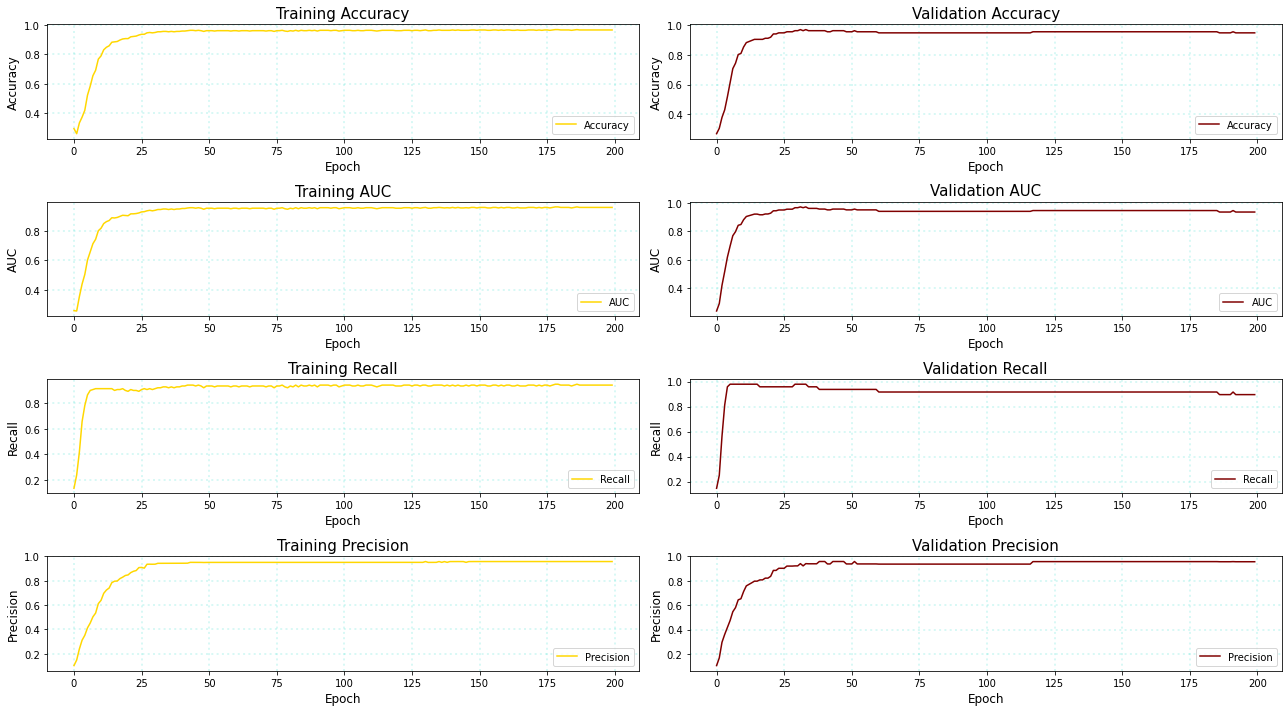

In [10]:
# Show Recall Precision
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 10))

def plot_measure_graph(x_data, y_data, ax, title="Generic Title", color="Black", parameter="Generic Measure"):
    ax.plot(x_data, y_data, label=parameter, color=color)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(parameter, fontsize=12)
    ax.grid(b=True, color="Turquoise", alpha=0.2, linestyle=':', linewidth=2)
    ax.legend()

train_acc_x, train_acc_y = zip(*training_notes['train_acc'])
val_acc_x, val_acc_y = zip(*training_notes['val_acc'])
train_auc_x, train_auc_y = zip(*training_notes['train_auc'])
val_auc_x, val_auc_y = zip(*training_notes['val_auc'])
train_recall_x, train_recall_y = zip(*training_notes['train_recall'])
val_recall_x, val_recall_y = zip(*training_notes['val_recall'])
train_prec_x, train_prec_y = zip(*training_notes['train_precision'])
val_prec_x, val_prec_y = zip(*training_notes['val_precision'])

plot_measure_graph(train_acc_x, train_acc_y, ax=axs[0][0], title="Training Accuracy", color="Gold", parameter="Accuracy")
plot_measure_graph(val_acc_x, val_acc_y, ax=axs[0][1], title="Validation Accuracy", color="Maroon", parameter="Accuracy")
plot_measure_graph(train_auc_x, train_auc_y, ax=axs[1][0], title="Training AUC", color="Gold", parameter="AUC")
plot_measure_graph(val_auc_x, val_auc_y, ax=axs[1][1], title="Validation AUC", color="Maroon", parameter="AUC")
plot_measure_graph(train_recall_x, train_recall_y, ax=axs[2][0], title="Training Recall", color="Gold", parameter="Recall")
plot_measure_graph(val_recall_x, val_recall_y, ax=axs[2][1], title="Validation Recall", color="Maroon", parameter="Recall")
plot_measure_graph(train_prec_x, train_prec_y, ax=axs[3][0], title="Training Precision", color="Gold", parameter="Precision")
plot_measure_graph(val_prec_x, val_prec_y, ax=axs[3][1], title="Validation Precision", color="Maroon", parameter="Precision")
fig.tight_layout()
plt.show()

# Final Statistics


Model Test Set Performance Statistics:
Test Set Accuracy:	 0.964
Test Set AUC:		 0.962
Test Set Recall:	 0.958
Test Set Precision:	 0.939


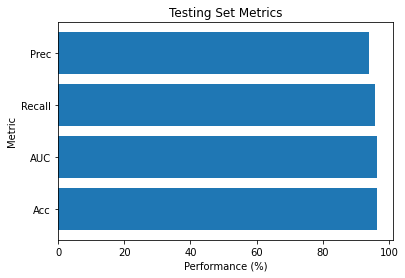

In [11]:
# Evaluate the model on testing data we set aside
test_acc, test_auc, test_recall, test_prec = evaluate_model(test_dl, model)

y = [test_acc, test_auc, test_recall, test_prec]
y_percent = [i * 100 for i in y]
plt.barh(['Acc', 'AUC', 'Recall', 'Prec'], y_percent)
plt.ylabel('Metric')
plt.xlabel('Performance (%)')
plt.title('Testing Set Metrics')

print('\nModel Test Set Performance Statistics:')
print('Test Set Accuracy:\t %.3f' % test_acc)
print('Test Set AUC:\t\t %.3f' % test_auc)
print('Test Set Recall:\t %.3f' % test_recall)
print('Test Set Precision:\t %.3f' % test_prec)